In [3]:
import os
import pandas as pd
import requests
from natural_pdf import PDF

df = pd.read_csv("div2_data_2023_2024.csv")

pdf_folder = "pdfs"
os.makedirs(pdf_folder, exist_ok=True)

for _, row in df.iterrows():
    url = row["PDF_URL"]
    school = row["School"]
    filename = f"{school.replace(' ', '_').replace(',', '')}.pdf"
    filepath = os.path.join(pdf_folder, filename)

    if os.path.exists(filepath):
        print(f"Already downloaded: {school}")
        continue

    try:
        print(f"Downloading: {school}")
        response = requests.get(url)
        response.raise_for_status()
        with open(filepath, "wb") as f:
            f.write(response.content)
        print(f"Saved to {filepath}")
    except Exception as e:
        print(f"Failed to download {school}: {e}")

pdf_files = sorted([f for f in os.listdir(pdf_folder) if f.endswith(".pdf")])

for filename in pdf_files:
    filepath = os.path.join(pdf_folder, filename)
    print(f"Processing: {filename}")
    
    pdf = PDF(filepath)
    
    if not pdf.pages:
        print("No pages found in this PDF.")
        continue

    page = pdf.pages[0]
    try:
        page.find("text").show()
    except Exception as e:
        print(f"Could not show bounding boxes for {filename}: {e}")

Already downloaded: Augustana University (South Dakota)
Already downloaded: Barry University
Already downloaded: Bellarmine University
Already downloaded: Bemidji State University
Already downloaded: Benedict College
Already downloaded: Bentley University
Already downloaded: Bloomsburg University of Pennsylvania
Already downloaded: Bowie State University
Already downloaded: University of Bridgeport
Already downloaded: California State Polytechnic University, Pomona
Already downloaded: California State University, Dominguez Hills
Already downloaded: California State University, San Bernardino
Already downloaded: California State University, Chico
Already downloaded: California State University, East Bay
Already downloaded: California State University, Los Angeles
Already downloaded: California State University, Stanislaus
Already downloaded: Pennsylvania Western University, California
Already downloaded: University of California, San Diego
Already downloaded: University of Central Misso

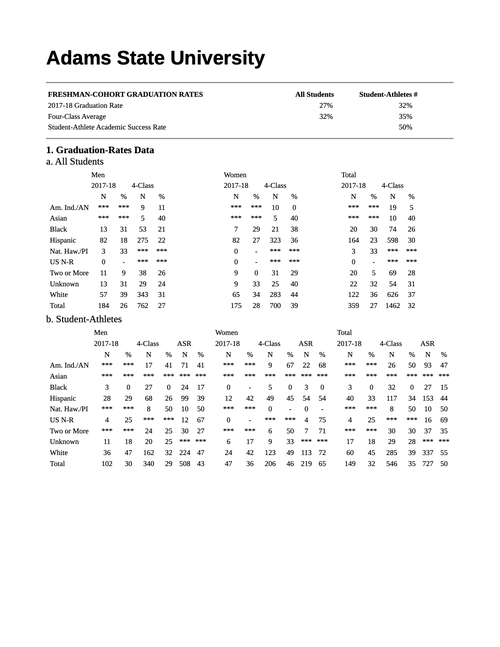

In [4]:
filename = "Adams_State_University.pdf"
filepath = os.path.join("pdfs", filename)

pdf = PDF(filepath)

page = pdf.pages[0]
page.to_image(width=500)

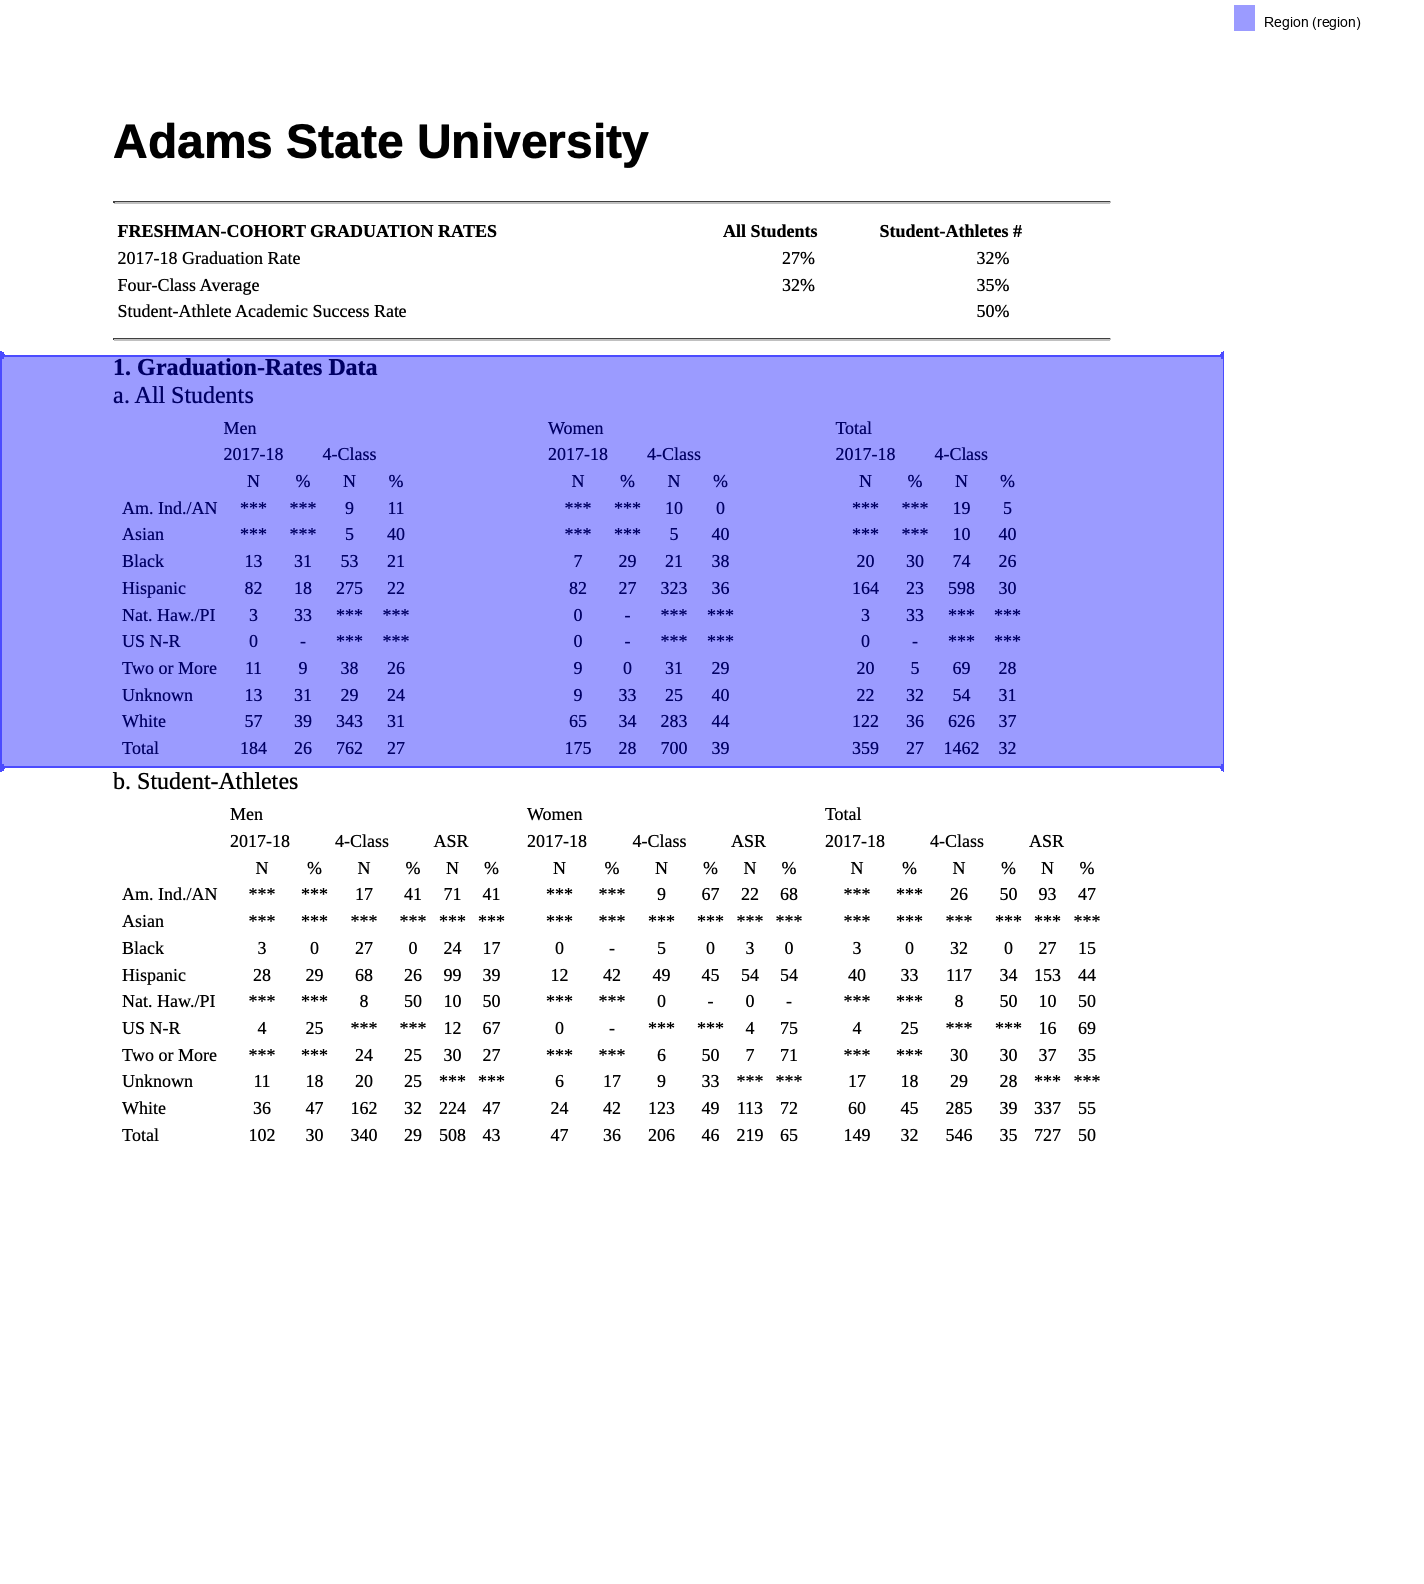

In [5]:
(
    page
    .find(text='b. Student-Athletes')
    .above(until='text:contains("Graduation-Rates Data")')
    .show()
)

In [6]:
rows = table.extract_table(table_settings={'snap_y_tolerance': 5})
rows

NameError: name 'table' is not defined

In [ ]:
table_2 = (
    page

    .find(text='b. Student-Athletes')
    .below()
)
table_2.show()

In [10]:
def deduplicate_columns(columns):
    seen = {}
    deduped = []
    for col in columns:
        if col not in seen:
            seen[col] = 1
            deduped.append(col)
        else:
            seen[col] += 1
            deduped.append(f"{col}_{seen[col]-1}")
    return deduped

def extract_school_name(filename):
    return filename.replace(".pdf", "").replace("_", " ").strip()

pdf_folder = "pdfs"
pdf_files = sorted([f for f in os.listdir(pdf_folder) if f.endswith(".pdf")])
all_rows = []

for filename in pdf_files:
    filepath = os.path.join(pdf_folder, filename)
    school_name = extract_school_name(filename)
    pdf = PDF(filepath)

    if not pdf.pages:
        print(f"No pages in {filename}")
        continue

    page = pdf.pages[0]

    try:
        table_all = page.find(text='b. Student-Athletes').above(until='text:contains("Graduation-Rates Data")')
        rows_all = table_all.extract_table(table_settings={'snap_y_tolerance': 8})

        if not rows_all or len(rows_all) < 3:
            print(f"Could not find header + data rows in {school_name} (All Students)")
            continue

        base_header = rows_all[0][1:]
        sub_header = rows_all[1][1:]
        combined_cols = [f"{b} {s}" for b, s in zip(base_header, sub_header)]
        full_header = ["Race"] + combined_cols
        data = rows_all[2:]
        data_padded = [row[:len(full_header)] + [""] * (len(full_header) - len(row)) for row in data]
        df_all = pd.DataFrame(data_padded, columns=full_header)
        df_all["Source"] = "All Students"
        df_all["School"] = school_name

        table_ath = page.find(text='b. Student-Athletes').below()
        rows_ath = table_ath.extract_table(table_settings={'snap_y_tolerance': 8})

        if not rows_ath or len(rows_ath) < 3:
            print(f"Could not find header + data rows in {school_name} (Student-Athletes)")
            continue

        base_header_ath = rows_ath[0][1:]
        sub_header_ath = rows_ath[1][1:]
        combined_cols_ath = [f"{b} {s}" for b, s in zip(base_header_ath, sub_header_ath)]
        full_header_ath = ["Race"] + [f"Student-Athletes {col}" for col in combined_cols_ath]
        data_ath = rows_ath[2:]
        data_ath_padded = [row[:len(full_header_ath)] + [""] * (len(full_header_ath) - len(row)) for row in data_ath]
        df_ath = pd.DataFrame(data_ath_padded, columns=full_header_ath)

        combined = pd.merge(df_all, df_ath, on="Race", how="outer")
        combined.columns = deduplicate_columns(combined.columns)
        all_rows.append(combined)

        print(f"Finished {school_name}")

    except Exception as e:
        print(f"Failed to process {filename}: {e}")

if all_rows:
    final_df = pd.concat(all_rows, ignore_index=True)
    final_df.to_csv("Page1_AllSchools.csv", index=False)
    print("Saved: Page1_AllSchools.csv")
else:
    print("No data extracted.")

KeyboardInterrupt: 